In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# data load

In [3]:
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [4]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
diabetes_df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

# 성능평가 지표 확인 

In [9]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)

    print(f'혼동행렬: ')
    print(confusion)
    print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall}, f1: {f1}, AUC: {auc},')

# 차트

In [11]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

# 모델 생성 / 학습 

In [12]:
y = diabetes_df.iloc[:, -1]
X = diabetes_df.iloc[:, :-1]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=150, stratify=y)

In [14]:
lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, -1]

get_clf_eval(y_test, pred, pred_proba)

혼동행렬: 
[[89 11]
 [25 29]]
정확도: 0.7662337662337663, 정밀도: 0.725, 재현율: 0.5370370370370371, f1: 0.6170212765957447, AUC: 0.7135185185185186,


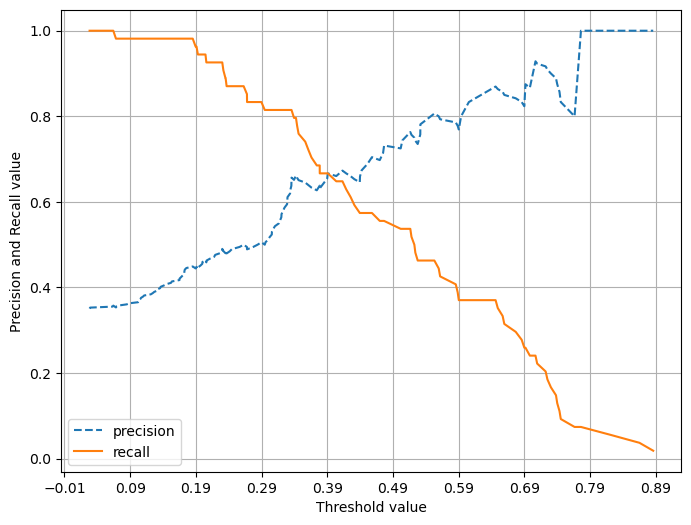

In [ ]:
# 음성예측율  
precision_recall_curve_plot(y_test, pred_proba)

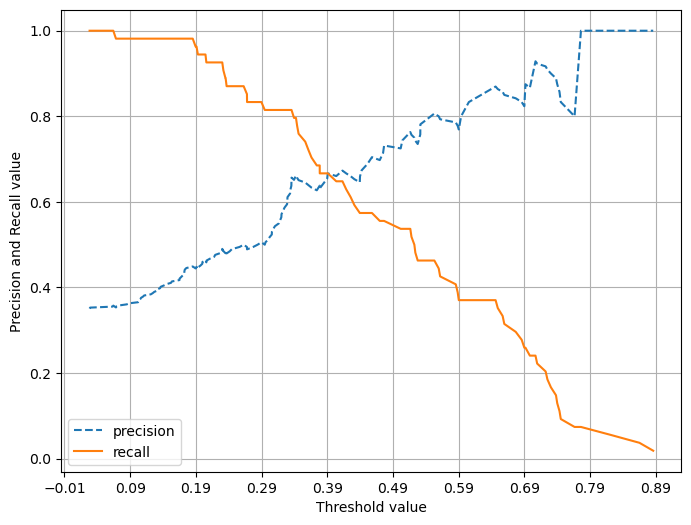

In [18]:
# 양성예측율  
pred_proba_1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_1)

In [19]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# 전처리

### 0 값 처리

In [20]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 0 값은 평균으로 
mean_df = diabetes_df[zero_features].mean()
diabetes_df[zero_features] = diabetes_df[zero_features].replace(0, mean_df)

# scaling 

In [21]:
y = diabetes_df.iloc[:, -1]
X = diabetes_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=150, stratify=y)

lr_clf = LogisticRegression(solver = 'liblinear') # 모델 생성 
lr_clf.fit(X_train, y_train)  # 학습 
pred = lr_clf.predict(X_test)  # 예측  
pred_proba = lr_clf.predict_proba(X_test)[:, -1]  

get_clf_eval(y_test, pred, pred_proba)

혼동행렬: 
[[88 12]
 [25 29]]
정확도: 0.7597402597402597, 정밀도: 0.7073170731707317, 재현율: 0.5370370370370371, f1: 0.6105263157894737, AUC: 0.7085185185185187,


# 재현율 수치 개선

In [22]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [23]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)

get_eval_by_threshold(y_test, pred_proba[:, -1].reshape(-1,1), thresholds)

임곗값: 0.3
혼동행렬: 
[[61 39]
 [10 44]]
정확도: 0.6818181818181818, 정밀도: 0.5301204819277109, 재현율: 0.8148148148148148, f1: 0.6423357664233577, AUC: 0.7124074074074074,
임곗값: 0.33
혼동행렬: 
[[68 32]
 [12 42]]
정확도: 0.7142857142857143, 정밀도: 0.5675675675675675, 재현율: 0.7777777777777778, f1: 0.65625, AUC: 0.7288888888888888,
임곗값: 0.36
혼동행렬: 
[[78 22]
 [18 36]]
정확도: 0.7402597402597403, 정밀도: 0.6206896551724138, 재현율: 0.6666666666666666, f1: 0.6428571428571429, AUC: 0.7233333333333333,
임곗값: 0.39
혼동행렬: 
[[80 20]
 [20 34]]
정확도: 0.7402597402597403, 정밀도: 0.6296296296296297, 재현율: 0.6296296296296297, f1: 0.6296296296296297, AUC: 0.7148148148148149,
임곗값: 0.42
혼동행렬: 
[[81 19]
 [25 29]]
정확도: 0.7142857142857143, 정밀도: 0.6041666666666666, 재현율: 0.5370370370370371, f1: 0.5686274509803921, AUC: 0.6735185185185186,
임곗값: 0.45
혼동행렬: 
[[84 16]
 [25 29]]
정확도: 0.7337662337662337, 정밀도: 0.6444444444444445, 재현율: 0.5370370370370371, f1: 0.5858585858585859, AUC: 0.6885185185185185,
임곗값: 0.48
혼동행렬: 
[[86 14]
 [25 29]]
정확도: 0.746753246